# Deconfounded Recommender

Dataset - Kaggle Movies Dataset

Author - Mahima

# Baseline Model - Probabilistic Matrix Factorization (PMF)



In [30]:
import os
import sys
import pickle
import warnings
import numpy as np 
import pandas as pd 
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split

randseed = 29266137


download the dataset and unzip it for further use.

In [2]:
os.environ['KAGGLE_USERNAME'] = "mahimagaur3131" # username from the json file
os.environ['KAGGLE_KEY'] = "f283ab784cb9afd472c90766acabc801" # key from the json file

#Movies Dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset
!unzip the-movies-dataset.zip

 95% 217M/228M [00:01<00:00, 191MB/s]
100% 228M/228M [00:01<00:00, 169MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [3]:
df = pd.read_csv('ratings_small.csv')
df = df[['userId', 'movieId', 'rating']]
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


Prepare the sparse review matrix R.

In [4]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 0])
    uniq_movies = np.unique(df_values[:, 1])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [5]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [6]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [7]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [8]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [9]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [10]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [11]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [12]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [13]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -27629.399783032357
Log p a-posteriori at iteration 20 : -18749.159910719412
Log p a-posteriori at iteration 30 : -15499.199304651382
Log p a-posteriori at iteration 40 : -13828.137860616216
Log p a-posteriori at iteration 50 : -12814.626206647246
Log p a-posteriori at iteration 60 : -12158.291720802146
Log p a-posteriori at iteration 70 : -11716.500947866094
Log p a-posteriori at iteration 80 : -11409.778386288792
Log p a-posteriori at iteration 90 : -11189.984197844427
Log p a-posteriori at iteration 100 : -11019.573961354483
Log p a-posteriori at iteration 110 : -10880.013032004126
Log p a-posteriori at iteration 120 : -10758.876582385588
Log p a-posteriori at iteration 130 : -10654.859213985572
Log p a-posteriori at iteration 140 : -10572.438570042252
Log p a-posteriori at iteration 150 : -10502.446085693644


Now let's take a look at some graphs

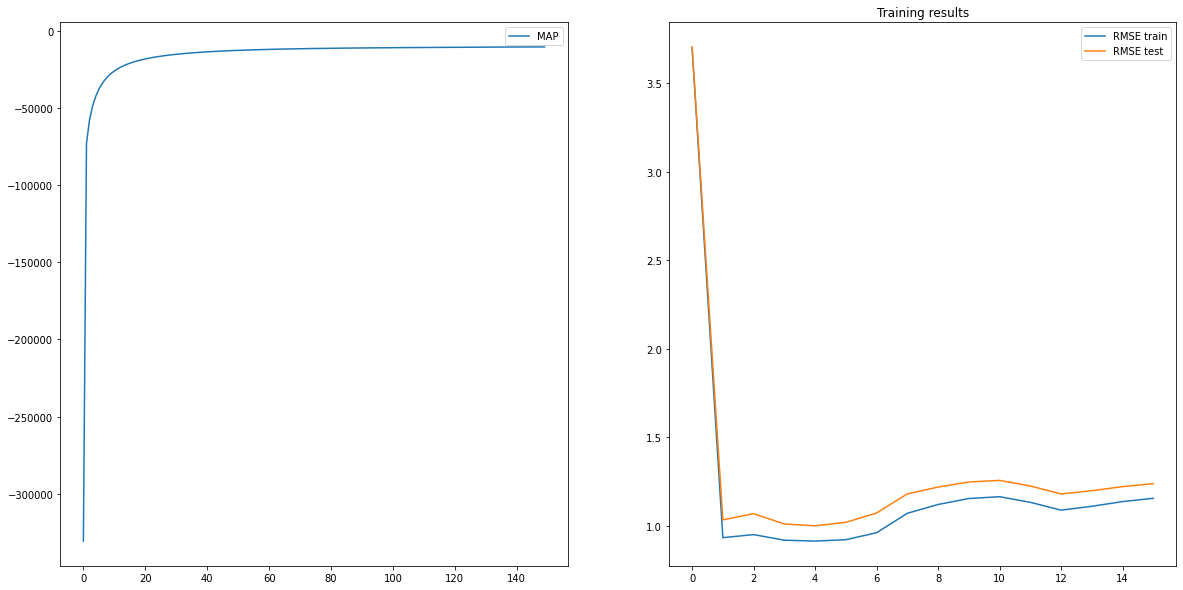

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [15]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.1553022783143079
RMSE of testing set: 1.2378647020723668


# The Deconfounder in Action



Poisson Matrix Factorization  - The Exposure Model

Preparing the exposure data.

In [22]:
def exposure_data(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    
    uniq_users = np.unique(df['userId'])
    uniq_movies = np.unique(df['movieId'])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    data = []
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    for row in df.iterrows():
      user, movie = row[1][0], row[1][1]
      data.append((user_to_row[user], movie_to_column[movie], 1))

    exposure_df = pd.DataFrame(data, columns =['userID', 'movieID', 'a'])
    #Train-test split
    df_copy = exposure_df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    return exposure_df, train_set, test_set, n_users, n_movies, user_to_row, movie_to_column


exposure_df, train, test, n_users, n_movies, user_to_row, movie_to_column = exposure_data(df)

Step 1 - Fit the exposure model

In [23]:
! pip install hpfrec
import pandas as pd, numpy as np
from hpfrec import HPF
exposure_df.columns = ['UserId', 'ItemId', 'Count']
recommender = HPF()
param = recommender.fit(exposure_df)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 671
Number of items: 9066
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -338484 | train rmse: 0.8521
Iteration 20 | train llk: -280626 | train rmse: 0.7591
Iteration 30 | train llk: -276980 | train rmse: 0.7552
Iteration 40 | train llk: -276400 | train rmse: 0.7552
Iteration 50 | train llk: -276295 | train rmse: 0.7557
Iteration 60 | train llk: -276310 | train rmse: 0.7561
Iteration 70 | train llk: -276309 | train rmse: 0.7565
Iteration 80 | train llk: -276309 | train rmse: 0.7567
Iteration 90 | train llk: -276342 | train rmse: 0.7568
Iteration 100 | train llk: -276385 | train rmse: 0.7569


Optimization finished
Final log-likelihood: -276385
Final RMSE: 0.7569
Minutes taken (optimization part): 0.6



Some data preprocessing

In [24]:
def matrix_X(R):
  X = []
  for i in range(len(R)):
    row = [1 if val == 1 else 0 for val in R[i]]
    X.append(row)
  return X

X = matrix_X(R)
ratings = df['rating']
y = R
pmfU = param.Theta

y_scaler = preprocessing.StandardScaler().fit(y)
y_scaled = y_scaler.fit_transform(y)

X_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = X_scaler.fit_transform(X)

pmfU_scaler = preprocessing.StandardScaler().fit(pmfU)
pmfU_scaled = pmfU_scaler.fit_transform(pmfU)

X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=randseed)
y_train, y_test = train_test_split(y_scaled, test_size=0.20, random_state=randseed)
pmfU_train, pmfU_test = train_test_split(pmfU_scaled, test_size=0.20, random_state=randseed)
n_users, n_items = X_train.shape

Step 2 - Fit the outcome model

In [ ]:
import warnings
warnings.filterwarnings('ignore')
reg = linear_model.Ridge(normalize=True)
for i in range(n_items):
    # if i%100 == 0:
    #   print('---- Fitting row', i, '----')
    reg.fit(np.column_stack([X_train[:,i], pmfU_train]), y_train[:,i])

Step 4 - Estimate potential ratings

In [ ]:
test_items = X_test.shape[1]
prediction = []

for i in range(test_items):
    # if i%100 == 0:
    #   print('---- Predicting row', i, '----')
    res = reg.predict(np.column_stack([X_test[:,i], pmfU_test]))
    prediction.append(res)

Evaluate the model

In [39]:
y_test = np.transpose(y_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
print(rmse)

0.780996536081642


*   Baseline MSE = 1.2
*   Decounder MSE = 0.7


